In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torch.optim import Adam
import torchvision.transforms.functional as fn

import os
import time
import math
import numpy as np
import matplotlib.pyplot as plt

from di_dataset import DepthImageDataset

from torch.utils.tensorboard import SummaryWriter

In [18]:
writer = SummaryWriter('runs/vae_cifar10')

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Load Dataset

In [19]:
saves_folders = "../../../rl_data"
load_paths = [os.path.join(saves_folders, saves_folder) for saves_folder in os.listdir(saves_folders)]

In [20]:
load_path = "../../../rl_data/saves_2"

In [21]:
# Hyperparams
latent_dim = 800 
num_epochs = 20
batch_size = 1
learning_rate = 1e-3

In [22]:
# Obtain train and test data
dataset = DepthImageDataset(load_path=load_path) # Can only do 1 pickle file for now

Loading from ../../../rl_data/saves_2


100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.47it/s]


In [23]:
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=0)
len(train_loader), len(test_loader), len(train_dataset), len(test_dataset)

(1, 1, 1, 1)

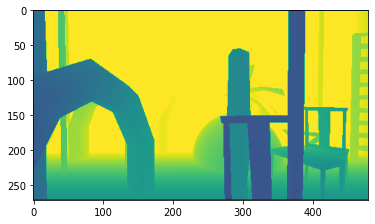

torch.Size([1, 272, 480])

In [24]:
dataiter = iter(train_loader)
image_batch = dataiter.next()

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

for image in image_batch:
    imshow(image)
    
image.shape

In [25]:
image_batch.squeeze().mean(), image_batch.squeeze().var()

(tensor(0.7420), tensor(0.0769))

# Define Variational Autoencoder


In [26]:
class VAE(nn.Module):
    def __init__(self, input_channels, feature_dim=31*57, latent_dim=500) -> None:
        super(VAE, self).__init__()
        # (input width - filter size + 2*padding)/stride + 1
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=2),
            nn.ReLU()
        )
        
        self.fc_mu = nn.Linear(64*feature_dim, latent_dim)
        self.fc_logvar = nn.Linear(64*feature_dim, latent_dim)
        
        self.fc_z = nn.Linear(latent_dim, 64*feature_dim)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, input_channels, kernel_size=5, stride=2, output_padding=1),
            nn.ReLU(),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Inference
        x_enc = self.encoder(x)
        x_enc = x_enc.view(-1, 64*31*57)
        
        mu = self.fc_mu(x_enc)
        logvar = self.fc_logvar(x_enc)

        # Reparametrisation
        std = torch.exp(logvar/2)
        epsilon = torch.randn_like(std) # generate eps [0,1) with dim matching std
        z = mu + std * epsilon

        # Generate
        x_hat = self.fc_z(z)
        x_hat = x_hat.view(-1, 64, 31, 57)
        x_hat = self.decoder(x_hat)
        
        return mu, logvar, x_hat
    
vae_model = VAE(input_channels=1)

In [34]:
from torchsummary import summary
summary(vae_model, (1, 272, 480))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 134, 238]             416
              ReLU-2         [-1, 16, 134, 238]               0
            Conv2d-3          [-1, 32, 65, 117]          12,832
              ReLU-4          [-1, 32, 65, 117]               0
            Conv2d-5           [-1, 64, 31, 57]          51,264
              ReLU-6           [-1, 64, 31, 57]               0
            Linear-7                  [-1, 800]      90,471,200
            Linear-8                  [-1, 800]      90,471,200
            Linear-9               [-1, 113088]      90,583,488
  ConvTranspose2d-10          [-1, 32, 65, 117]          51,232
             ReLU-11          [-1, 32, 65, 117]               0
  ConvTranspose2d-12         [-1, 16, 134, 238]          12,816
             ReLU-13         [-1, 16, 134, 238]               0
  ConvTranspose2d-14          [-1, 1, 2

# Training

In [27]:
def loss_function(x, x_hat, mean, log_var):
    #reproduction_loss = nn.BCELoss(reduction='sum')(x_hat, x)
    reproduction_loss = F.binary_cross_entropy(x_hat, x, reduction="sum")
    KLD      = 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss - KLD

In [28]:
# def loss_function(x, x_hat, mu, logvar):
#     reproduction_loss = F.mse_loss(x_hat, x, reduction="sum")
#     kl_divergence = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

#     return reproduction_loss - kl_divergence

In [29]:
n_training_samples = len(train_dataset)
n_iterations = math.ceil(n_training_samples/batch_size)
n_training_samples, n_iterations

(1, 1)

In [30]:
vae_model = VAE(input_channels=1, latent_dim=latent_dim)
optimiser = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)

In [31]:
for epoch in range(num_epochs):
    overall_loss = 0
    since = time.time()
    for i, image in enumerate(train_loader):

        optimiser.zero_grad()

        # VAE forward pass
        mu, logvar, x_hat = vae_model(image)

        # Loss
        loss = loss_function(image, x_hat, mu, logvar)

        overall_loss += loss

        # Update weights
        loss.backward()
        optimiser.step()

        if (i+1) % 1 == 0:
            time_elapsed = time.time() - since
            #print(f"epoch: {epoch+1}/{num_epochs}, step: {i+1}/{n_iterations}, image: {image.shape}")
            print(f"epoch: {epoch+1}/{num_epochs}, step: {i+1}/{n_iterations}, Avg loss: {overall_loss/((i+1)*batch_size):.3f}, time: {time_elapsed:.3f}")


epoch: 1/20, step: 1/1, Avg loss: 88147.578, time: 1.331
epoch: 2/20, step: 1/1, Avg loss: 88780.320, time: 1.327
epoch: 3/20, step: 1/1, Avg loss: 86367.250, time: 1.477
epoch: 4/20, step: 1/1, Avg loss: 85092.320, time: 1.393
epoch: 5/20, step: 1/1, Avg loss: 80409.281, time: 1.419
epoch: 6/20, step: 1/1, Avg loss: 69847.188, time: 1.281
epoch: 7/20, step: 1/1, Avg loss: 74282.078, time: 1.240
epoch: 8/20, step: 1/1, Avg loss: 60657.102, time: 1.281
epoch: 9/20, step: 1/1, Avg loss: 57025.883, time: 1.386
epoch: 10/20, step: 1/1, Avg loss: 55725.008, time: 1.240
epoch: 11/20, step: 1/1, Avg loss: 53849.371, time: 1.293
epoch: 12/20, step: 1/1, Avg loss: 52770.637, time: 1.314
epoch: 13/20, step: 1/1, Avg loss: 52671.801, time: 1.437
epoch: 14/20, step: 1/1, Avg loss: 52471.141, time: 1.454
epoch: 15/20, step: 1/1, Avg loss: 52199.863, time: 1.286
epoch: 16/20, step: 1/1, Avg loss: 51244.422, time: 1.231
epoch: 17/20, step: 1/1, Avg loss: 51030.441, time: 1.260
epoch: 18/20, step: 1/1

# Evaluate

## Test set

tensor(0.7420) tensor(0.7842)
tensor(0.0769) tensor(0.0476)
torch.Size([1, 1, 272, 480])


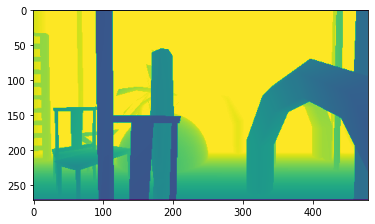

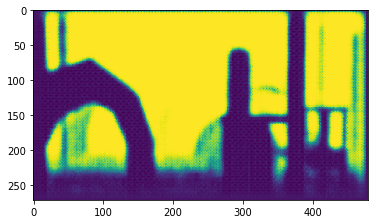

In [32]:
vae_model.eval()
# Visualise sample of images

with torch.no_grad():
    for images in test_loader:
        # VAE forward pass
        _, _, x_hat = vae_model(images)

        print(images.mean(), x_hat.mean())
        print(images.var(), x_hat.var())
        print(images.shape)
        for idx in range(1):
            # show images
            imshow(images[idx])
            imshow(x_hat[idx])

        # write to tensorboard
        # writer.add_image('four_cifar10_images', inv_normalize(img_grid))


## Training set

tensor(0.7420) tensor(0.7871)
tensor(0.0769) tensor(0.0474)
torch.Size([1, 1, 272, 480])


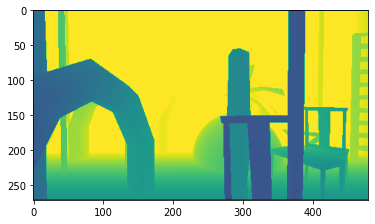

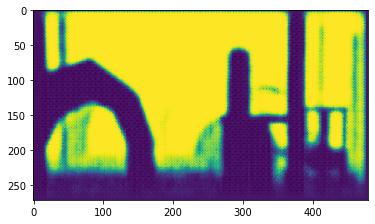

In [33]:
vae_model.eval()
# Visualise sample of images
with torch.no_grad():
    for images in train_loader:
        # VAE forward pass
        _, _, x_hat = vae_model(images)

        print(images.mean(), x_hat.mean())
        print(images.var(), x_hat.var())
        print(images.shape)
        for idx in range(1):
            # show images
            imshow(images[idx])
            imshow(x_hat[idx])
